## 3.1 Classification and regression with a two-layer perceptron
### 3.1.1 Classification of linearly non-separable data


=== Hidden-unit sweep (mean ± std over runs) ===
epochs=200, eta=0.01, alpha=0.9, runs_per_H=3
H | mis_mean ± std | mse_mean ± std | best_seed_for_boundary
--+----------------+---------------+----------------------
 1 |   36.00 ±  0.00 |  0.4695 ±  0.0000 | 1002
 2 |   36.00 ±  0.00 |  0.4689 ±  0.0001 | 2002
 4 |   12.00 ± 16.97 |  0.1596 ±  0.2176 | 4002
 7 |    0.00 ±  0.00 |  0.0380 ±  0.0207 | 7002
 8 |    0.00 ±  0.00 |  0.0149 ±  0.0072 | 8019
 9 |    0.00 ±  0.00 |  0.0080 ±  0.0025 | 9002
13 |    0.00 ±  0.00 |  0.0112 ±  0.0034 | 13002
18 |    0.00 ±  0.00 |  0.0058 ±  0.0010 | 18019
19 |    0.00 ±  0.00 |  0.0059 ±  0.0014 | 19002
20 |    0.00 ±  0.00 |  0.0055 ±  0.0007 | 20019
25 |    0.00 ±  0.00 |  0.0060 ±  0.0010 | 25019


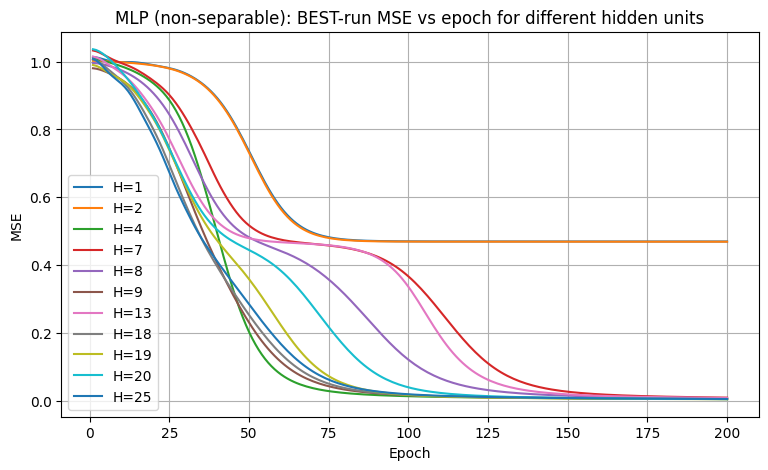

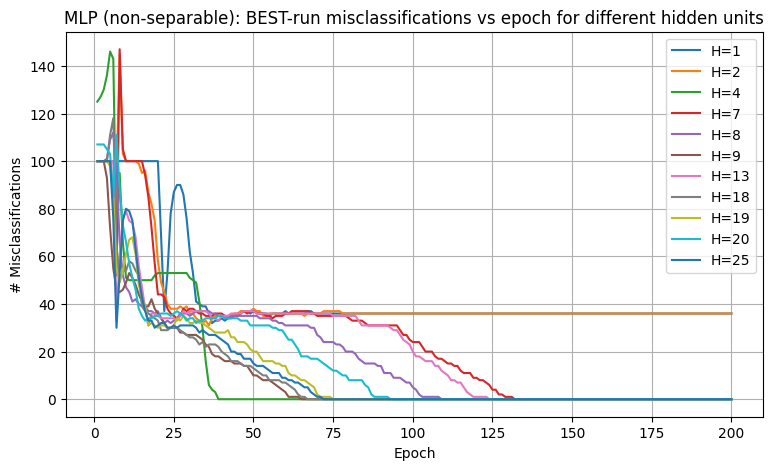

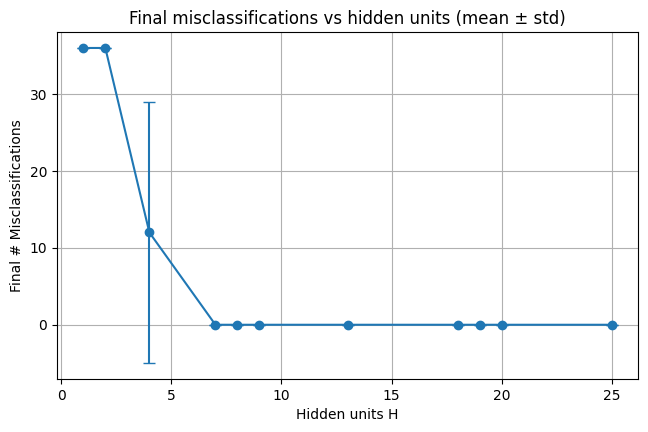

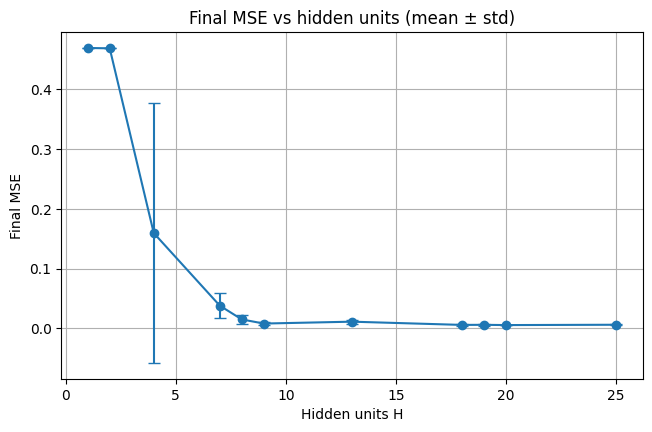

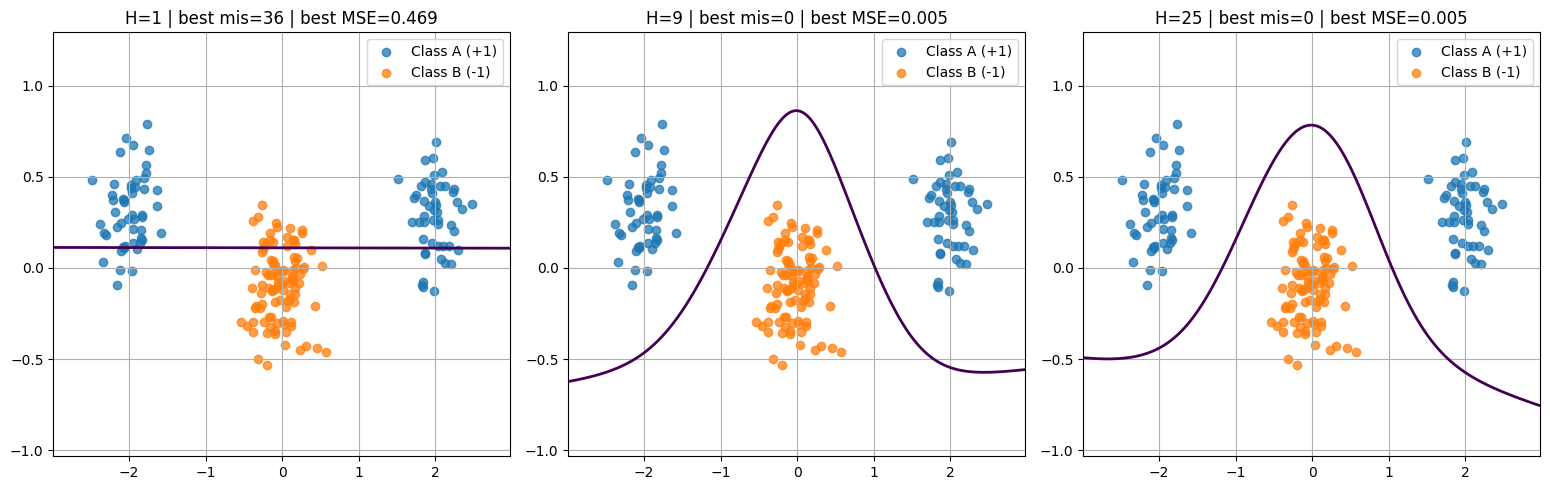


=== BEST model metrics on FULL set (per H) ===
H= 1  acc=0.820  sens=0.830  spec=0.810  (TP=83, TN=81, FP=19, FN=17)
H= 2  acc=0.820  sens=0.830  spec=0.810  (TP=83, TN=81, FP=19, FN=17)
H= 4  acc=1.000  sens=1.000  spec=1.000  (TP=100, TN=100, FP=0, FN=0)
H= 7  acc=1.000  sens=1.000  spec=1.000  (TP=100, TN=100, FP=0, FN=0)
H= 8  acc=1.000  sens=1.000  spec=1.000  (TP=100, TN=100, FP=0, FN=0)
H= 9  acc=1.000  sens=1.000  spec=1.000  (TP=100, TN=100, FP=0, FN=0)
H=13  acc=1.000  sens=1.000  spec=1.000  (TP=100, TN=100, FP=0, FN=0)
H=18  acc=1.000  sens=1.000  spec=1.000  (TP=100, TN=100, FP=0, FN=0)
H=19  acc=1.000  sens=1.000  spec=1.000  (TP=100, TN=100, FP=0, FN=0)
H=20  acc=1.000  sens=1.000  spec=1.000  (TP=100, TN=100, FP=0, FN=0)
H=25  acc=1.000  sens=1.000  spec=1.000  (TP=100, TN=100, FP=0, FN=0)


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Helpers (from your base code)
# ============================================================
def add_bias_row(X):
    return np.vstack([X, np.ones((1, X.shape[1]))])  # (d+1, N)

def predict_bipolar_from_scores(s):
    return np.where(s >= 0, 1.0, -1.0)

def confusion_stats(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == -1) & (y_pred == -1))
    FP = np.sum((y_true == -1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == -1))
    acc = (TP + TN) / max(1, (TP + TN + FP + FN))
    sens = TP / max(1, (TP + FN))
    spec = TN / max(1, (TN + FP))
    return {"TP": TP, "TN": TN, "FP": FP, "FN": FN, "acc": acc, "sens": sens, "spec": spec}

def fixed_axis_limits(X, pad=0.5):
    xmin, xmax = X[0].min() - pad, X[0].max() + pad
    ymin, ymax = X[1].min() - pad, X[1].max() + pad
    return xmin, xmax, ymin, ymax

# ============================================================
# DATA: MATLAB-like non-separable dataset (your function)
# ============================================================
def make_special_nonseparable_dataset(ndata=100, mA=(1.0, 0.3), sigmaA=0.2,
                                     mB=(0.0, -0.1), sigmaB=0.2, seed=0):
    rng = np.random.default_rng(seed)
    mA = np.array(mA, dtype=float)
    mB = np.array(mB, dtype=float)

    n1 = int(round(0.5 * ndata))
    n2 = ndata - n1

    A1_left  = rng.standard_normal(n1) * sigmaA - mA[0]
    A1_right = rng.standard_normal(n2) * sigmaA + mA[0]
    A1 = np.concatenate([A1_left, A1_right])
    A2 = rng.standard_normal(ndata) * sigmaA + mA[1]

    B1 = rng.standard_normal(ndata) * sigmaB + mB[0]
    B2 = rng.standard_normal(ndata) * sigmaB + mB[1]

    classA = np.vstack([A1, A2])  # (2,ndata)
    classB = np.vstack([B1, B2])  # (2,ndata)

    X = np.hstack([classA, classB])                  # (2,2*ndata)
    y = np.hstack([np.ones(ndata), -np.ones(ndata)]) # (2*ndata,)

    perm = rng.permutation(2 * ndata)
    return X[:, perm], y[perm], classA, classB

# ============================================================
# Bipolar sigmoid + derivative (computed from output)
# phi(x) = 2/(1+e^-x) - 1   in [-1,1]
# phi'(x) = 0.5*(1+phi)*(1-phi)
# ============================================================
def bipolar_sigmoid(z):
    # stable-ish for typical lab ranges
    return 2.0 / (1.0 + np.exp(-z)) - 1.0

def bipolar_sigmoid_prime_from_output(y):
    return 0.5 * (1.0 + y) * (1.0 - y)

# ============================================================
# Two-layer MLP (1 hidden layer), batch backprop
# Input: X (2,N) , targets t in {-1,+1} shape (N,)
# Params:
#   W: (H,3)    maps [x1,x2,1] -> hidden preact
#   V: (1,H+1)  maps [h;1] -> output preact
# ============================================================
def mlp_forward(X, W, V):
    Xb = add_bias_row(X)            # (3,N)
    zh = W @ Xb                     # (H,N)
    h  = bipolar_sigmoid(zh)        # (H,N)
    hb = add_bias_row(h)            # (H+1,N)
    zo = V @ hb                     # (1,N)
    o  = bipolar_sigmoid(zo)        # (1,N)
    return Xb, h, hb, o

def mlp_mse(o, t):
    # o: (1,N), t: (N,)
    return float(np.mean((t - o.ravel())**2))

def mlp_predict(W, V, X):
    _, _, _, o = mlp_forward(X, W, V)
    yhat = predict_bipolar_from_scores(o.ravel())  # threshold at 0
    return yhat, o.ravel()

def train_mlp_batch(X, t, H=5, eta=0.01, alpha=0.9, epochs=500, seed=0, init_std=0.1):
    rng = np.random.default_rng(seed)
    N = X.shape[1]

    W = rng.normal(0.0, init_std, size=(H, 3))
    V = rng.normal(0.0, init_std, size=(1, H + 1))

    dW_prev = np.zeros_like(W)
    dV_prev = np.zeros_like(V)

    mse_curve, mis_curve = [], []

    for ep in range(epochs):
        Xb, h, hb, o = mlp_forward(X, W, V)

        do = (o.ravel() - t) * bipolar_sigmoid_prime_from_output(o.ravel())
        do = do.reshape(1, N)

        V_no_bias = V[:, :-1]
        dh = (V_no_bias.T @ do) * bipolar_sigmoid_prime_from_output(h)

        gradV = (do @ hb.T) 
        gradW = (dh @ Xb.T)

        # Momentum update (lab style)
        dV = alpha * dV_prev - (1.0 - alpha) * gradV
        dW = alpha * dW_prev - (1.0 - alpha) * gradW
        V += eta * dV
        W += eta * dW
        dV_prev, dW_prev = dV, dW

        mse_curve.append(mlp_mse(o, t))
        yhat = predict_bipolar_from_scores(o.ravel())
        mis_curve.append(int(np.sum(yhat != t)))

    return W, V, np.array(mse_curve), np.array(mis_curve)

# ============================================================
# Plot decision boundary for MLP via contour o(x)=0
# ============================================================
def plot_mlp_boundary(ax, X, y, W, V, title="", grid_n=250):
    A = X[:, y == 1]
    B = X[:, y == -1]
    ax.scatter(A[0], A[1], alpha=0.75, label="Class A (+1)")
    ax.scatter(B[0], B[1], alpha=0.75, label="Class B (-1)")

    xmin, xmax, ymin, ymax = fixed_axis_limits(X, pad=0.5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)

    xs = np.linspace(xmin, xmax, grid_n)
    ys = np.linspace(ymin, ymax, grid_n)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.vstack([XX.ravel(), YY.ravel()])  # (2,grid_n^2)

    _, scores = mlp_predict(W, V, grid)         # scores in [-1,1]
    ZZ = scores.reshape(grid_n, grid_n)

    ax.contour(XX, YY, ZZ, levels=[0.0], linewidths=2)
    ax.set_title(title)
    ax.legend()

# ============================================================
# Experiment: vary hidden units, track MSE + miscls, show plots
# ============================================================
def partI_nonseparable_hidden_sweep(seed=2):
    # dataset generated ONCE
    X, y, _, _ = make_special_nonseparable_dataset(
        ndata=100, mA=(2.0, 0.3), sigmaA=0.2,
        mB=(0.0, -0.1), sigmaB=0.2,
        seed=seed
    )

    # sweep settings
    H_list = [1, 2, 4, 7, 8, 9, 13, 18, 19, 20, 25]
    epochs = 200
    eta = 0.01
    alpha = 0.9
    runs_per_H = 3

    # store best model for boundaries/curves, and store stats for average plots
    best_curves = {}     # per H: best model + curves
    summary = []         # per H: mean/std stats

    for H in H_list:
        best = {
            "mis": 10**9, "mse": np.inf, "W": None, "V": None,
            "mse_curve": None, "mis_curve": None, "run_seed": None
        }

        mis_runs = []
        mse_runs = []

        for r in range(runs_per_H):
            run_seed = seed + 1000*H + 17*r

            W, V, mse_curve, mis_curve = train_mlp_batch(
                X, y, H=H, eta=eta, alpha=alpha, epochs=epochs,
                seed=run_seed, init_std=0.2
            )

            final_mis = int(mis_curve[-1])
            final_mse = float(mse_curve[-1])

            mis_runs.append(final_mis)
            mse_runs.append(final_mse)

            # keep BEST run (for boundary plots and "best curve" overlays)
            if (final_mis < best["mis"]) or (final_mis == best["mis"] and final_mse < best["mse"]):
                best.update({
                    "mis": final_mis, "mse": final_mse, "W": W, "V": V,
                    "mse_curve": mse_curve, "mis_curve": mis_curve, "run_seed": run_seed
                })

        best_curves[H] = best

        # compute average + std across runs
        mis_mean, mis_std = float(np.mean(mis_runs)), float(np.std(mis_runs))
        mse_mean, mse_std = float(np.mean(mse_runs)), float(np.std(mse_runs))

        summary.append((H, mis_mean, mis_std, mse_mean, mse_std, best["run_seed"]))

    # ---- print summary table (mean ± std + best seed used for boundary) ----
    print("\n=== Hidden-unit sweep (mean ± std over runs) ===")
    print(f"epochs={epochs}, eta={eta}, alpha={alpha}, runs_per_H={runs_per_H}")
    print("H | mis_mean ± std | mse_mean ± std | best_seed_for_boundary")
    print("--+----------------+---------------+----------------------")
    for H, mis_m, mis_s, mse_m, mse_s, best_seed in summary:
        print(f"{H:2d} | {mis_m:7.2f} ± {mis_s:5.2f} | {mse_m:7.4f} ± {mse_s:7.4f} | {best_seed}")

    # ---- overlay learning curves of BEST run per H (optional but useful) ----
    xs = np.arange(1, epochs + 1)

    plt.figure(figsize=(9, 5))
    for H in H_list:
        plt.plot(xs, best_curves[H]["mse_curve"], label=f"H={H}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("MLP (non-separable): BEST-run MSE vs epoch for different hidden units")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(9, 5))
    for H in H_list:
        plt.plot(xs, best_curves[H]["mis_curve"], label=f"H={H}")
    plt.xlabel("Epoch")
    plt.ylabel("# Misclassifications")
    plt.title("MLP (non-separable): BEST-run misclassifications vs epoch for different hidden units")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- plot FINAL metrics vs H (MEAN ± STD) ----
    Hs       = np.array([s[0] for s in summary])
    mis_mean = np.array([s[1] for s in summary])
    mis_std  = np.array([s[2] for s in summary])
    mse_mean = np.array([s[3] for s in summary])
    mse_std  = np.array([s[4] for s in summary])

    plt.figure(figsize=(7.5, 4.5))
    plt.errorbar(Hs, mis_mean, yerr=mis_std, marker="o", capsize=4)
    plt.xlabel("Hidden units H")
    plt.ylabel("Final # Misclassifications")
    plt.title("Final misclassifications vs hidden units (mean ± std)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(7.5, 4.5))
    plt.errorbar(Hs, mse_mean, yerr=mse_std, marker="o", capsize=4)
    plt.xlabel("Hidden units H")
    plt.ylabel("Final MSE")
    plt.title("Final MSE vs hidden units (mean ± std)")
    plt.grid(True)
    plt.show()

    # ---- decision boundaries for a few H values (using BEST run per H) ----
    show_H = [H_list[0], H_list[len(H_list)//2], H_list[-1]]
    fig, axes = plt.subplots(1, len(show_H), figsize=(5.2*len(show_H), 5))
    if len(show_H) == 1:
        axes = [axes]

    for ax, H in zip(axes, show_H):
        W = best_curves[H]["W"]
        V = best_curves[H]["V"]
        title = f"H={H} | best mis={best_curves[H]['mis']} | best MSE={best_curves[H]['mse']:.3f}"
        plot_mlp_boundary(ax, X, y, W, V, title=title, grid_n=250)

    plt.tight_layout()
    plt.show()

    # ---- extra: print acc/sens/spec for BEST models ----
    print("\n=== BEST model metrics on FULL set (per H) ===")
    for H in H_list:
        W = best_curves[H]["W"]
        V = best_curves[H]["V"]
        yhat, _ = mlp_predict(W, V, X)
        st = confusion_stats(y, yhat)
        print(f"H={H:2d}  acc={st['acc']:.3f}  sens={st['sens']:.3f}  spec={st['spec']:.3f}  "
              f"(TP={st['TP']}, TN={st['TN']}, FP={st['FP']}, FN={st['FN']})")

# ============================================================
# Run
# ============================================================
if __name__ == "__main__":
    partI_nonseparable_hidden_sweep(seed=2)



=== Scenario: Random 25% from each class ===
Train N=150, Val N=50
Final Train: mis=0  mse=0.0003
Final Val:   mis=0  mse=0.0003


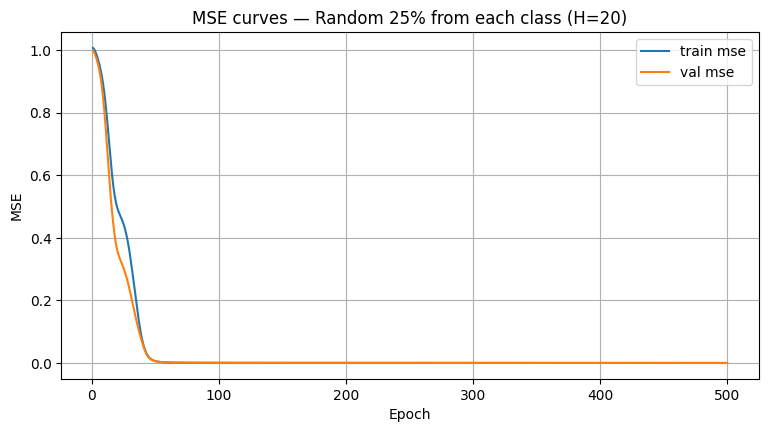

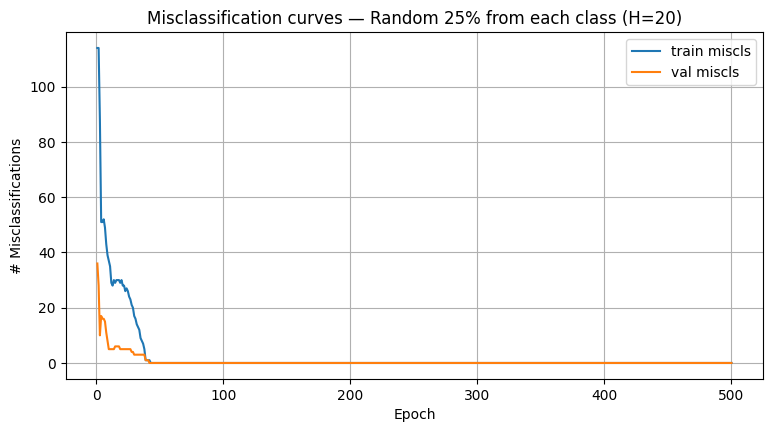

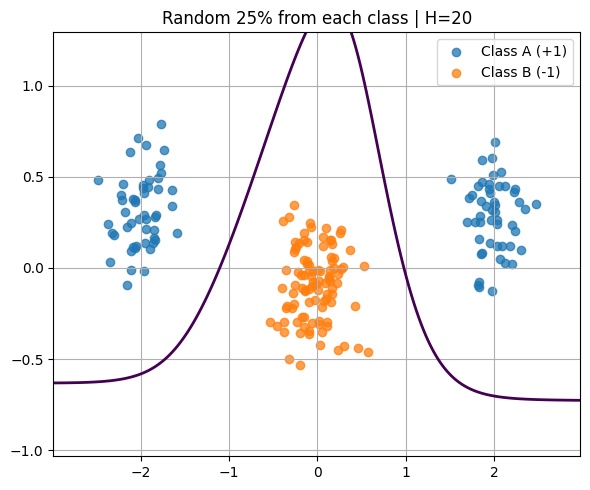


=== Scenario: Random 50% from classA ===
Train N=150, Val N=50
Final Train: mis=0  mse=0.0003
Final Val:   mis=0  mse=0.0003


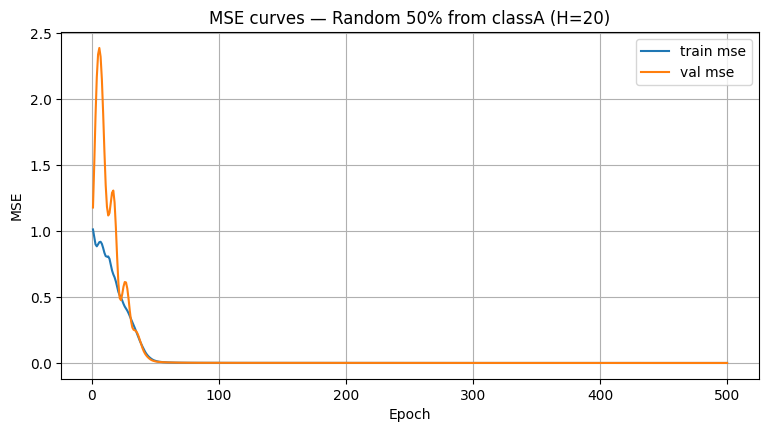

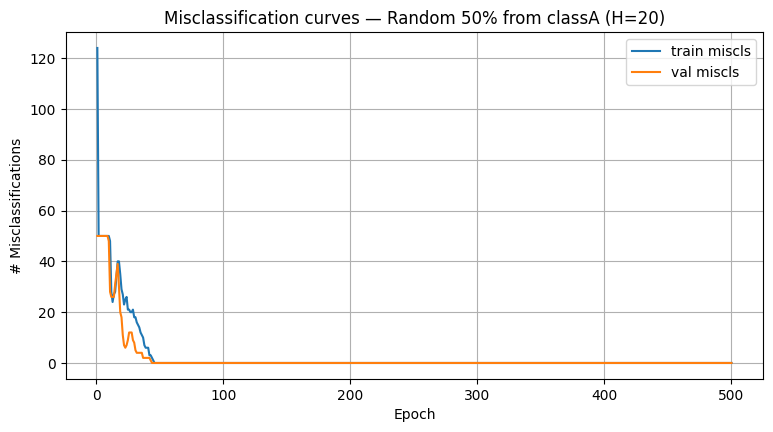

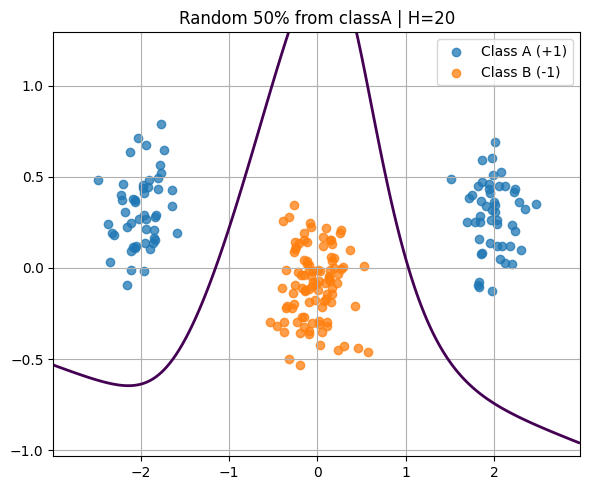


=== Scenario: 20% of A (x<0) + 80% of A (x>0) ===
Train N=150, Val N=50
Final Train: mis=10  mse=0.2667
Final Val:   mis=40  mse=3.2000


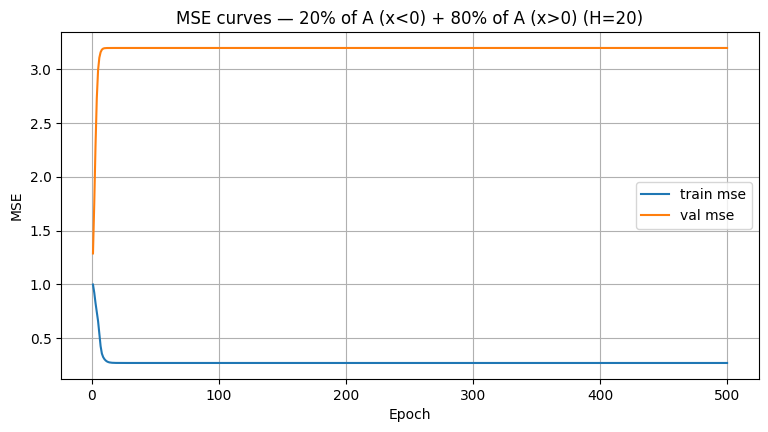

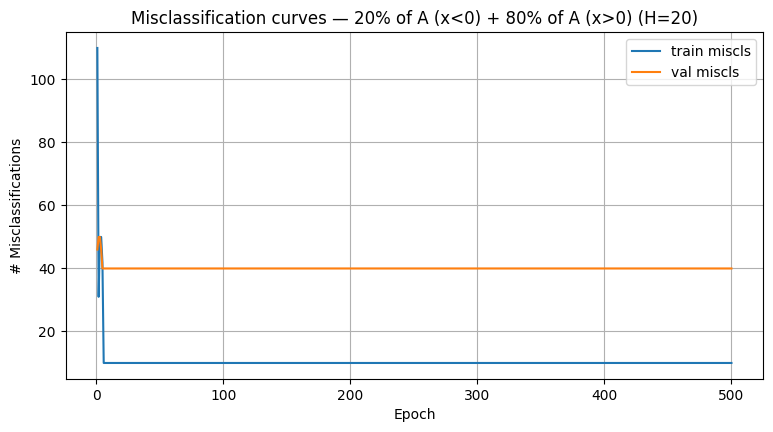

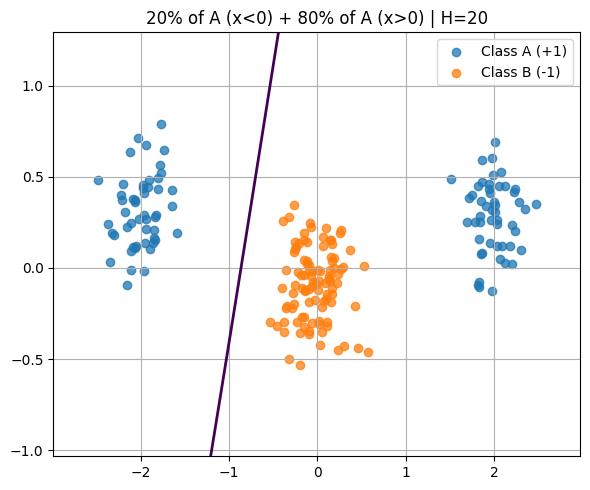


=== Scenario: Random 25% from each class ===
Train N=150, Val N=50
Final Train: mis=0  mse=0.0004
Final Val:   mis=0  mse=0.0010


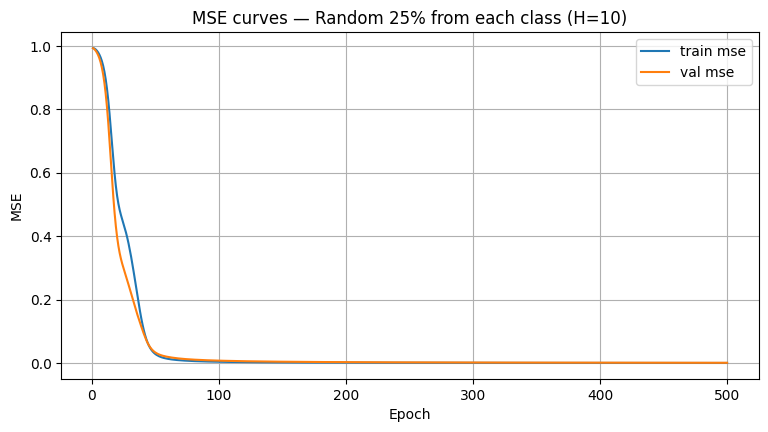

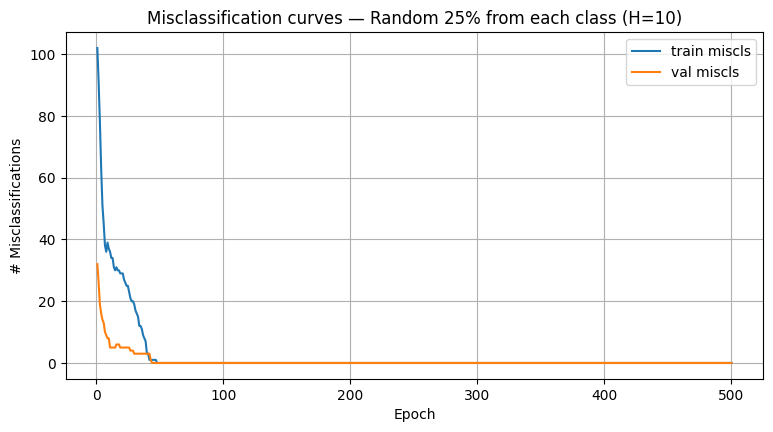

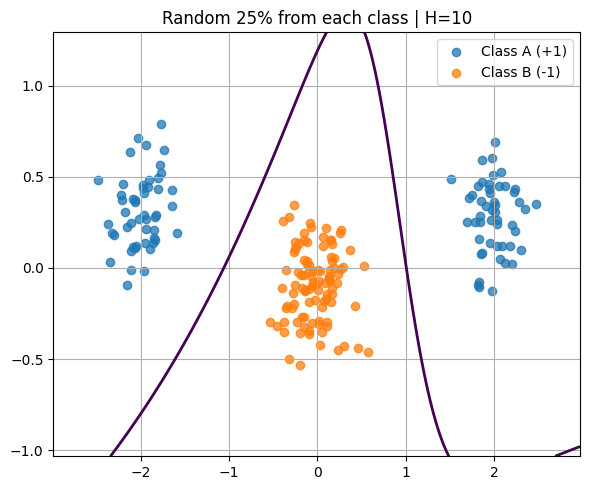


=== Scenario: Random 50% from classA ===
Train N=150, Val N=50
Final Train: mis=0  mse=0.0004
Final Val:   mis=0  mse=0.0004


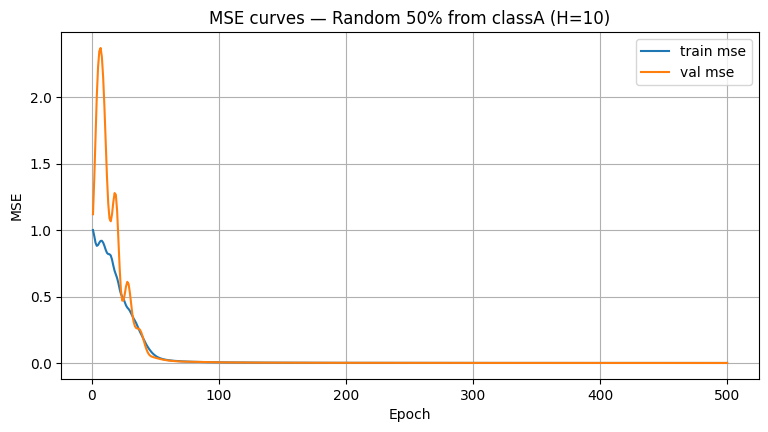

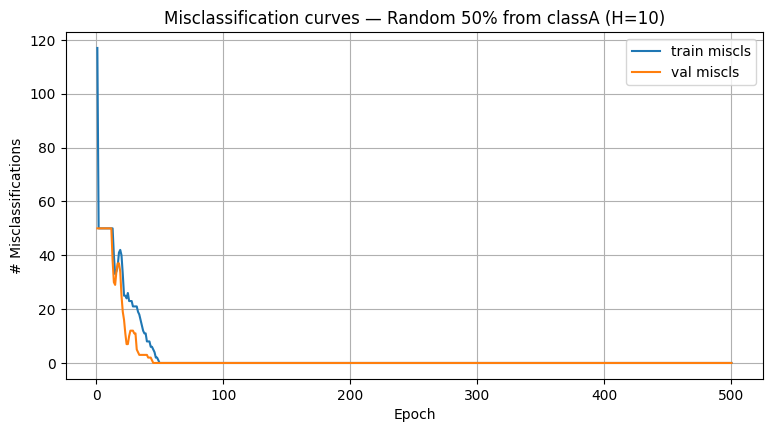

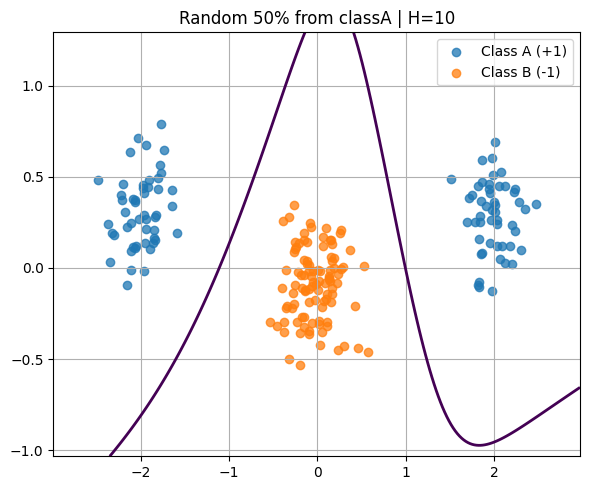


=== Scenario: 20% of A (x<0) + 80% of A (x>0) ===
Train N=150, Val N=50
Final Train: mis=10  mse=0.2667
Final Val:   mis=40  mse=3.2000


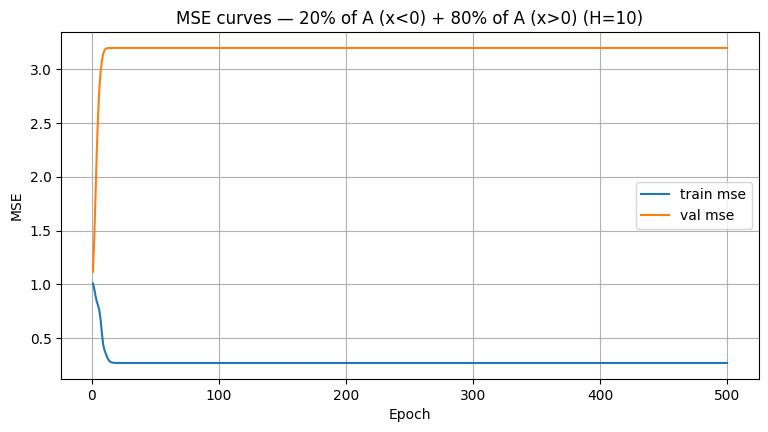

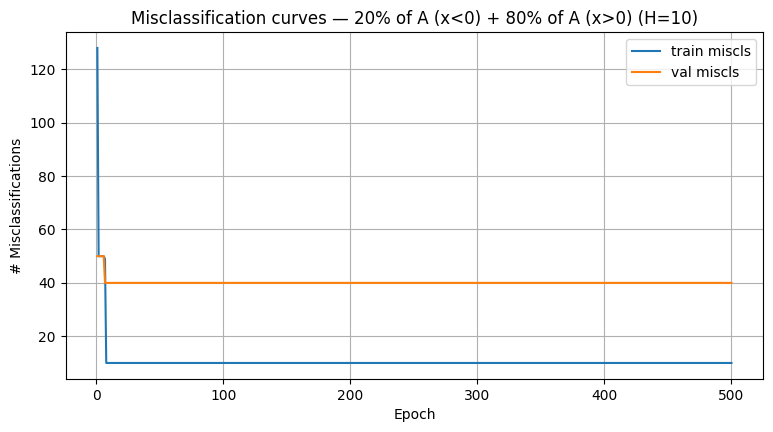

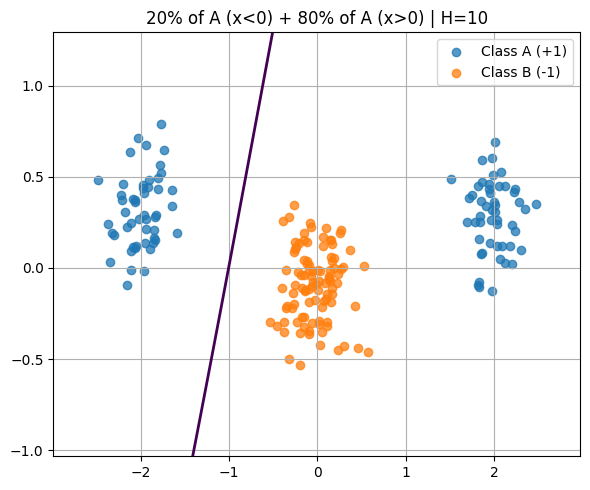

In [15]:
def build_class_masks(X, y):
    isA = (y == 1)
    isB = (y == -1)
    A_x_lt0 = isA & (X[0, :] < 0)
    A_x_gt0 = isA & (X[0, :] > 0)
    return isA, isB, A_x_lt0, A_x_gt0


def split_train_val_scenario(X, y, scenario, seed=0):
    rng = np.random.default_rng(seed)
    N = X.shape[1]
    idx_all = np.arange(N)

    isA, isB, A_x_lt0, A_x_gt0 = build_class_masks(X, y)
    idx_A = idx_all[isA]
    idx_B = idx_all[isB]

    if scenario == "25_each":
        nA = int(round(0.25 * len(idx_A)))
        nB = int(round(0.25 * len(idx_B)))

        idx_val = np.concatenate([
            rng.choice(idx_A, nA, replace=False),
            rng.choice(idx_B, nB, replace=False)
        ])

    elif scenario == "50_A":
        nA = int(round(0.50 * len(idx_A)))
        idx_val = rng.choice(idx_A, nA, replace=False)

    elif scenario == "A_20_80":
        idx_lt0 = idx_all[A_x_lt0]
        idx_gt0 = idx_all[A_x_gt0]

        n_lt0 = max(1, int(round(0.20 * len(idx_lt0))))
        n_gt0 = max(1, int(round(0.80 * len(idx_gt0))))

        idx_val = np.concatenate([
            rng.choice(idx_lt0, min(n_lt0, len(idx_lt0)), replace=False),
            rng.choice(idx_gt0, min(n_gt0, len(idx_gt0)), replace=False)
        ])

    else:
        raise ValueError("Unknown scenario")

    idx_val = np.unique(idx_val)
    idx_tr = np.setdiff1d(idx_all, idx_val)

    return X[:, idx_tr], y[idx_tr], X[:, idx_val], y[idx_val]


def train_mlp_batch_with_val(Xtr, ytr, Xva, yva, H=5, eta=0.01, alpha=0.9, epochs=500, seed=0, init_std=0.1):
    rng = np.random.default_rng(seed)
    Ntr = Xtr.shape[1]

    W = rng.normal(0.0, init_std, size=(H, 3))
    V = rng.normal(0.0, init_std, size=(1, H + 1))

    dW_prev = np.zeros_like(W)
    dV_prev = np.zeros_like(V)

    tr_mse, tr_mis, va_mse, va_mis = [], [], [], []

    for ep in range(epochs):
        # ---- train forward ----
        Xb, h, hb, o = mlp_forward(Xtr, W, V)

        do = (o.ravel() - ytr) * bipolar_sigmoid_prime_from_output(o.ravel())
        do = do.reshape(1, Ntr)

        dh = (V[:, :-1].T @ do) * bipolar_sigmoid_prime_from_output(h)

        gradV = (do @ hb.T) 
        gradW = (dh @ Xb.T) 

        # momentum update
        dV = alpha * dV_prev - (1.0 - alpha) * gradV
        dW = alpha * dW_prev - (1.0 - alpha) * gradW
        V += eta * dV
        W += eta * dW
        dV_prev, dW_prev = dV, dW

        # train metrics
        tr_mse.append(mlp_mse(o, ytr))
        tr_mis.append(int(np.sum(predict_bipolar_from_scores(o.ravel()) != ytr)))

        # val metrics
        _, _, _, o_va = mlp_forward(Xva, W, V)
        va_mse.append(mlp_mse(o_va, yva))
        va_mis.append(int(np.sum(predict_bipolar_from_scores(o_va.ravel()) != yva)))

    return W, V, np.array(tr_mse), np.array(tr_mis), np.array(va_mse), np.array(va_mis)

def run_validation_scenarios_on_same_data(X, y, seed_split=10, H=8, epochs=2000, eta=0.05, alpha=0.9):
    scenarios = [
        ("25_each", "Random 25% from each class"),
        ("50_A",    "Random 50% from classA"),
        ("A_20_80", "20% of A (x<0) + 80% of A (x>0)")
    ]

    for scen_key, scen_name in scenarios:
        Xtr, ytr, Xva, yva = split_train_val_scenario(X, y, scen_key, seed=seed_split)

        W, V, tr_mse, tr_mis, va_mse, va_mis = train_mlp_batch_with_val(
            Xtr, ytr, Xva, yva, H=H, eta=eta, alpha=alpha, epochs=epochs, seed=2, init_std=0.2
        )

        print(f"\n=== Scenario: {scen_name} ===")
        print(f"Train N={Xtr.shape[1]}, Val N={Xva.shape[1]}")
        print(f"Final Train: mis={tr_mis[-1]}  mse={tr_mse[-1]:.4f}")
        print(f"Final Val:   mis={va_mis[-1]}  mse={va_mse[-1]:.4f}")

        xs = np.arange(1, epochs+1)

        plt.figure(figsize=(9,4.5))
        plt.plot(xs, tr_mse, label="train mse")
        plt.plot(xs, va_mse, label="val mse")
        plt.title(f"MSE curves — {scen_name} (H={H})")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.grid(True)
        plt.legend()
        plt.show()

        plt.figure(figsize=(9,4.5))
        plt.plot(xs, tr_mis, label="train miscls")
        plt.plot(xs, va_mis, label="val miscls")
        plt.title(f"Misclassification curves — {scen_name} (H={H})")
        plt.xlabel("Epoch")
        plt.ylabel("# Misclassifications")
        plt.grid(True)
        plt.legend()
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        plot_mlp_boundary(ax, X, y, W, V, title=f"{scen_name} | H={H}")
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    # Generate data ONCE
    X, y, classA, classB = make_special_nonseparable_dataset(
        ndata=100, mA=(2.0, 0.3), sigmaA=0.2,
        mB=(0.0, -0.1), sigmaB=0.2,
        seed=2
    )
    
     # Part I.2 (train/val scenarios) on SAME data
    run_validation_scenarios_on_same_data(X, y, seed_split=10, H=20, epochs=500, eta=0.05, alpha=0.9)
    run_validation_scenarios_on_same_data(X, y, seed_split=10, H=10, epochs=500, eta=0.05, alpha=0.9)



=== Compare Batch vs Sequential | scenario=25_each | H=20 ===
Train N=150, Val N=50
Final BATCH:      train mis=0 mse=0.0003 | val mis=0 mse=0.0003
Final SEQUENTIAL: train mis=0 mse=0.0004 | val mis=0 mse=0.0004


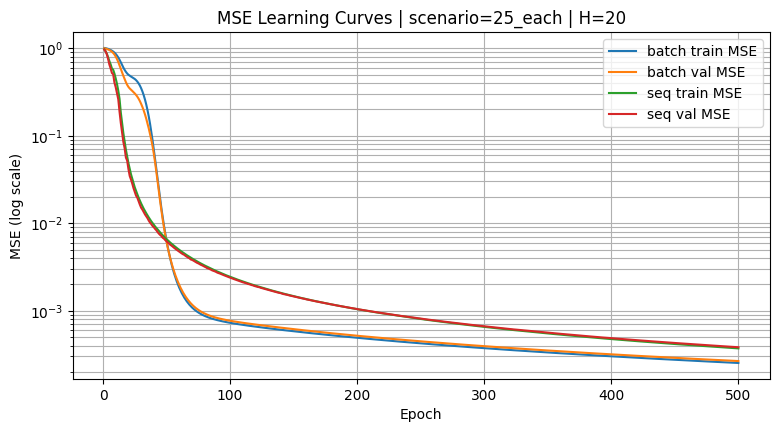

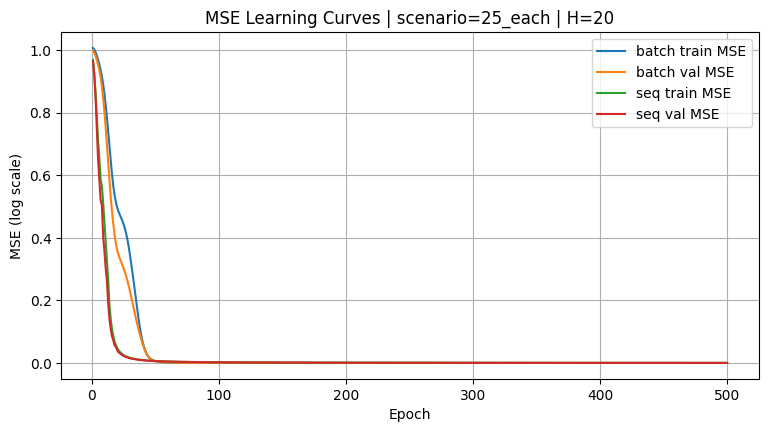

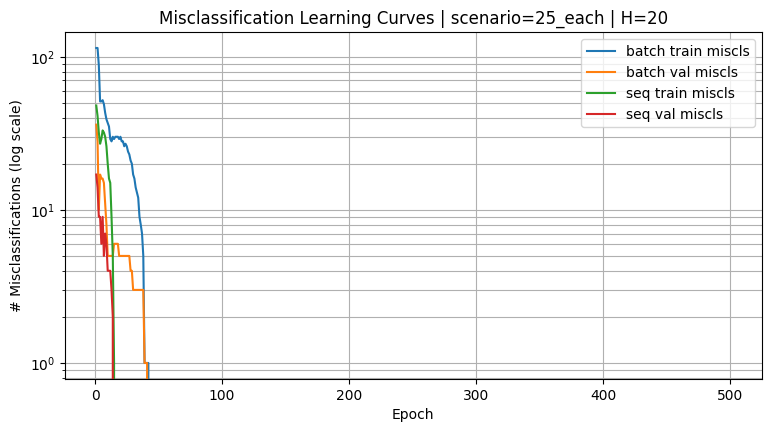

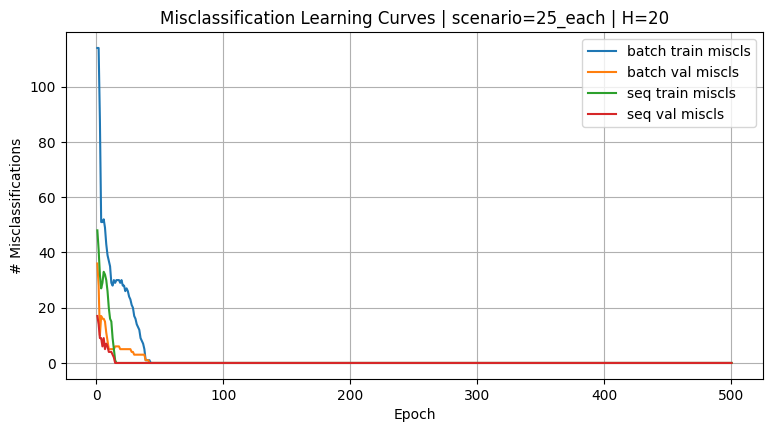

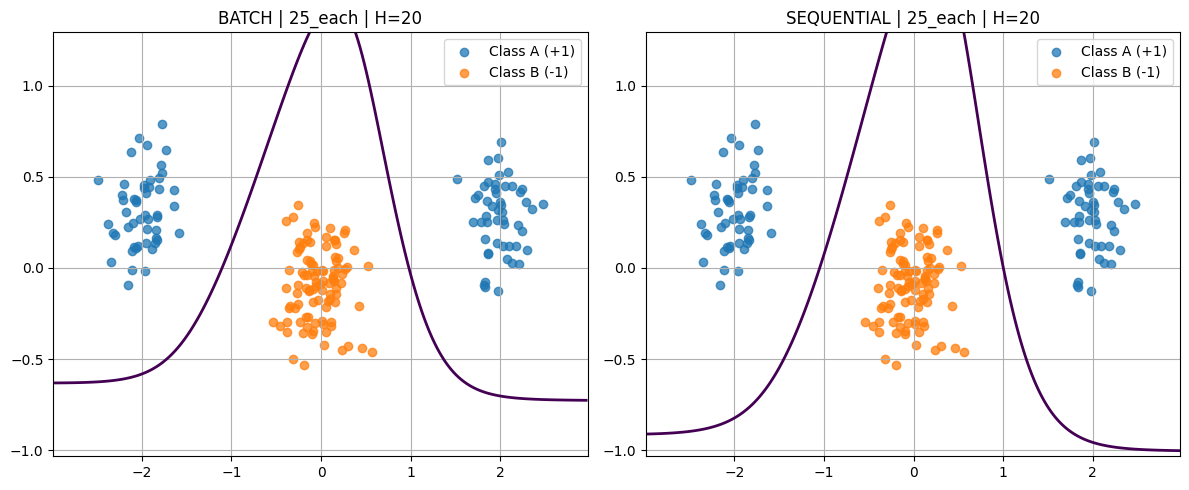


=== Compare Batch vs Sequential | scenario=25_each | H=20 ===
Train N=150, Val N=50
Final BATCH:      train mis=0 mse=0.0003 | val mis=0 mse=0.0003
Final SEQUENTIAL: train mis=0 mse=0.0004 | val mis=0 mse=0.0004


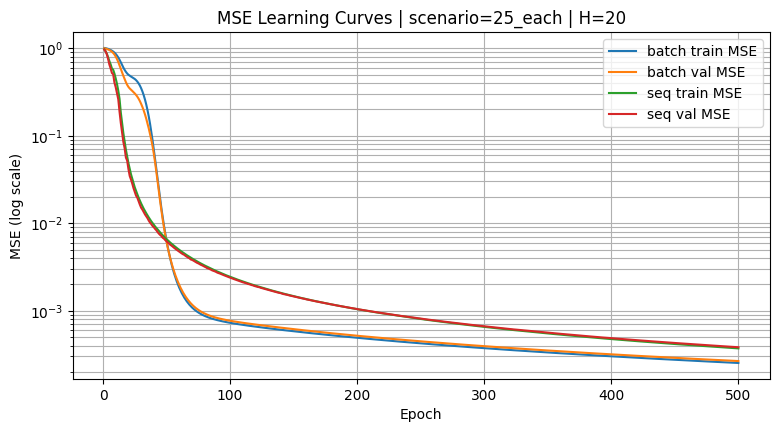

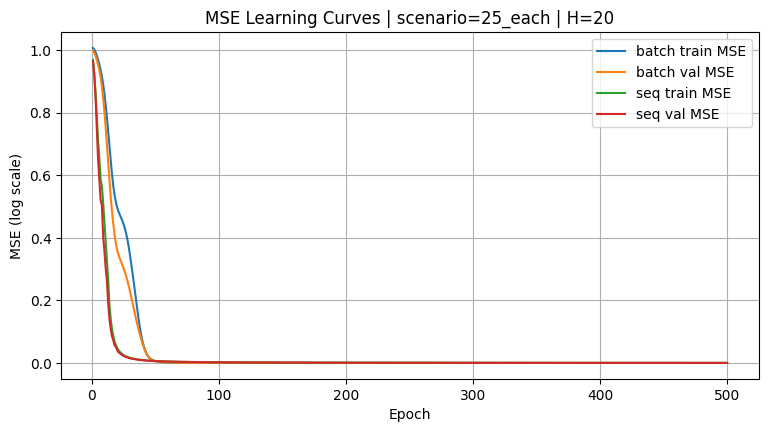

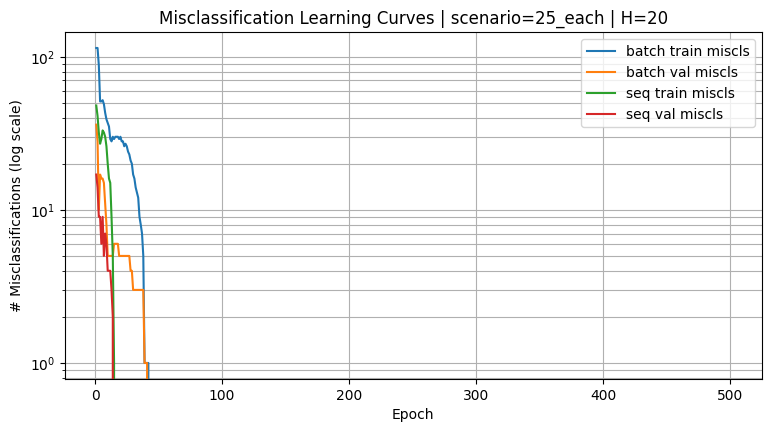

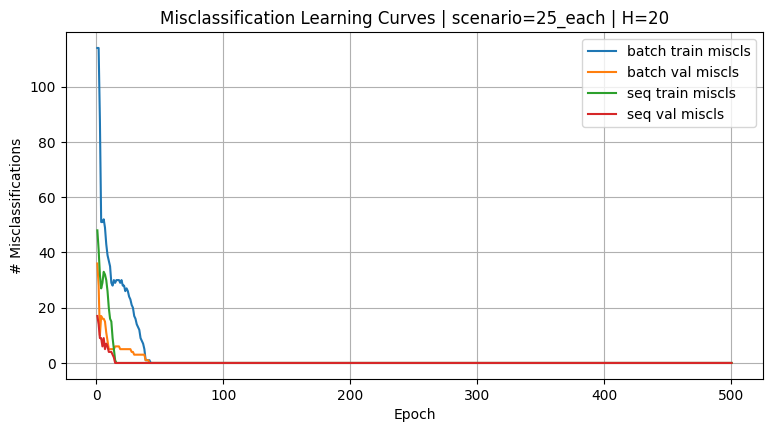

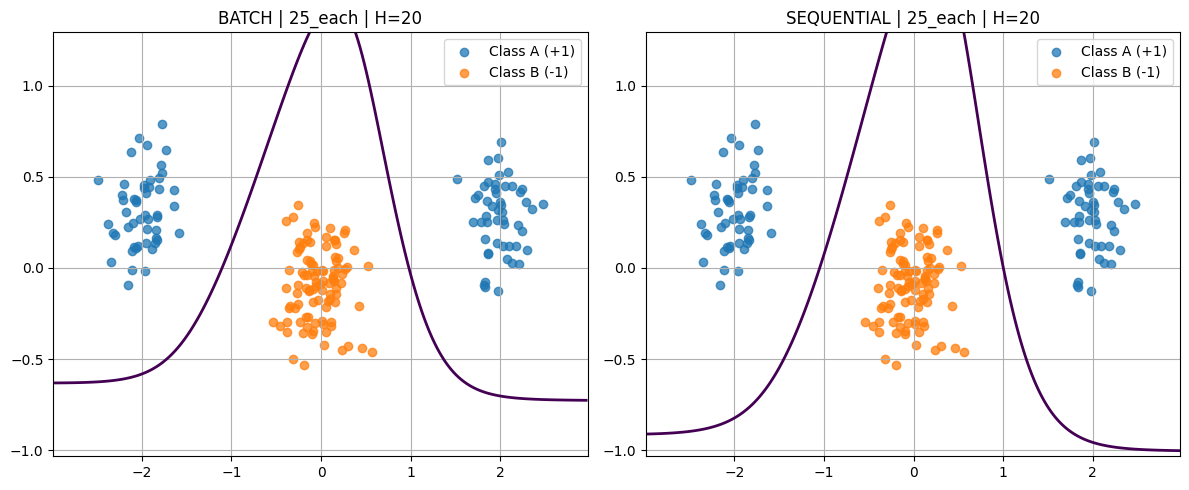

In [16]:
def train_mlp_sequential_with_val(
    Xtr, ytr, Xva, yva,
    H=20, eta=0.05, alpha=0.9, epochs=2500,
    seed_init=2, seed_shuffle=123, init_std=0.2
):
    """
    Sequential (online) learning:
      - updates weights after each sample
      - momentum implemented in the same style as your batch code
      - returns train/val MSE and misclassifications per epoch
    """
    rng_init = np.random.default_rng(seed_init)
    rng_shuf = np.random.default_rng(seed_shuffle)

    # init weights
    W = rng_init.normal(0.0, init_std, size=(H, 3))        # (H,3)
    V = rng_init.normal(0.0, init_std, size=(1, H + 1))    # (1,H+1)

    # momentum buffers
    dW_prev = np.zeros_like(W)
    dV_prev = np.zeros_like(V)

    Ntr = Xtr.shape[1]

    tr_mse, tr_mis, va_mse, va_mis = [], [], [], []

    for ep in range(epochs):
        order = rng_shuf.permutation(Ntr)

        # ---- online updates ----
        for i in order:
            x_i = Xtr[:, i:i+1]      # (2,1)
            t_i = ytr[i:i+1]         # (1,)

            # forward pass (single sample)
            Xb, h, hb, o = mlp_forward(x_i, W, V)  # o: (1,1)

            # output delta
            do = (o.ravel() - t_i) * bipolar_sigmoid_prime_from_output(o.ravel())
            do = do.reshape(1, 1)

            # hidden delta
            dh = (V[:, :-1].T @ do) * bipolar_sigmoid_prime_from_output(h)  # (H,1)

            # gradients (no /N in sequential)
            gradV = do @ hb.T   # (1,H+1)
            gradW = dh @ Xb.T   # (H,3)

            # momentum update (same style)
            dV = alpha * dV_prev - (1.0 - alpha) * gradV
            dW = alpha * dW_prev - (1.0 - alpha) * gradW
            V += eta * dV
            W += eta * dW
            dV_prev, dW_prev = dV, dW

        # ---- end-of-epoch metrics ----
        _, _, _, o_tr = mlp_forward(Xtr, W, V)
        tr_mse.append(mlp_mse(o_tr, ytr))
        tr_mis.append(int(np.sum(predict_bipolar_from_scores(o_tr.ravel()) != ytr)))

        _, _, _, o_va = mlp_forward(Xva, W, V)
        va_mse.append(mlp_mse(o_va, yva))
        va_mis.append(int(np.sum(predict_bipolar_from_scores(o_va.ravel()) != yva)))

    return W, V, np.array(tr_mse), np.array(tr_mis), np.array(va_mse), np.array(va_mis)

def compare_batch_vs_sequential(
    X, y, scenario="25_each",
    seed_split=10,
    H=20, epochs=2500, eta=0.05, alpha=0.9,
    seed_init=2, seed_shuffle=123, init_std=0.2,
    show_boundaries=True
):
    # --- same split for both methods ---
    Xtr, ytr, Xva, yva = split_train_val_scenario(X, y, scenario, seed=seed_split)

    # --- batch ---
    Wb, Vb, tr_mse_b, tr_mis_b, va_mse_b, va_mis_b = train_mlp_batch_with_val(
        Xtr, ytr, Xva, yva,
        H=H, eta=eta, alpha=alpha, epochs=epochs,
        seed=seed_init, init_std=init_std
    )

    # --- sequential ---
    Ws, Vs, tr_mse_s, tr_mis_s, va_mse_s, va_mis_s = train_mlp_sequential_with_val(
        Xtr, ytr, Xva, yva,
        H=H, eta=eta, alpha=alpha, epochs=epochs,
        seed_init=seed_init, seed_shuffle=seed_shuffle, init_std=init_std
    )

    print(f"\n=== Compare Batch vs Sequential | scenario={scenario} | H={H} ===")
    print(f"Train N={Xtr.shape[1]}, Val N={Xva.shape[1]}")
    print(f"Final BATCH:      train mis={tr_mis_b[-1]} mse={tr_mse_b[-1]:.4f} | val mis={va_mis_b[-1]} mse={va_mse_b[-1]:.4f}")
    print(f"Final SEQUENTIAL: train mis={tr_mis_s[-1]} mse={tr_mse_s[-1]:.4f} | val mis={va_mis_s[-1]} mse={va_mse_s[-1]:.4f}")

    xs = np.arange(1, epochs + 1)

    # --- MSE curves ---
    plt.figure(figsize=(9, 4.5))
    plt.plot(xs, tr_mse_b, label="batch train MSE")
    plt.plot(xs, va_mse_b, label="batch val MSE")
    plt.plot(xs, tr_mse_s, label="seq train MSE")
    plt.plot(xs, va_mse_s, label="seq val MSE")
    plt.yscale("log")   # <<< ADD THIS
    plt.title(f"MSE Learning Curves | scenario={scenario} | H={H}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE (log scale)")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(9, 4.5))
    plt.plot(xs, tr_mse_b, label="batch train MSE")
    plt.plot(xs, va_mse_b, label="batch val MSE")
    plt.plot(xs, tr_mse_s, label="seq train MSE")
    plt.plot(xs, va_mse_s, label="seq val MSE")
    plt.title(f"MSE Learning Curves | scenario={scenario} | H={H}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE (log scale)")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

    
    
    # --- misclassification curves --
    plt.figure(figsize=(9, 4.5))
    plt.plot(xs, tr_mis_b, label="batch train miscls")
    plt.plot(xs, va_mis_b, label="batch val miscls")
    plt.plot(xs, tr_mis_s, label="seq train miscls")
    plt.plot(xs, va_mis_s, label="seq val miscls")
    plt.yscale("log")   # optional
    plt.title(f"Misclassification Learning Curves | scenario={scenario} | H={H}")
    plt.xlabel("Epoch")
    plt.ylabel("# Misclassifications (log scale)")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()


    plt.figure(figsize=(9, 4.5))
    plt.plot(xs, tr_mis_b, label="batch train miscls")
    plt.plot(xs, va_mis_b, label="batch val miscls")
    plt.plot(xs, tr_mis_s, label="seq train miscls")
    plt.plot(xs, va_mis_s, label="seq val miscls")
    plt.title(f"Misclassification Learning Curves | scenario={scenario} | H={H}")
    plt.xlabel("Epoch")
    plt.ylabel("# Misclassifications")
    plt.grid(True)
    plt.legend()
    plt.show()
    

    # --- optional: decision boundaries side-by-side ---
    if show_boundaries:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        plot_mlp_boundary(axes[0], X, y, Wb, Vb, title=f"BATCH | {scenario} | H={H}")
        plot_mlp_boundary(axes[1], X, y, Ws, Vs, title=f"SEQUENTIAL | {scenario} | H={H}")
        plt.tight_layout()
        plt.show()

    return (Wb, Vb, Ws, Vs)
if __name__ == "__main__":
    X, y, classA, classB = make_special_nonseparable_dataset(
        ndata=100, mA=(2.0, 0.3), sigmaA=0.2,
        mB=(0.0, -0.1), sigmaB=0.2,
        seed=2
    )

    # Compare on ONE scenario (recommended), e.g. biased or 25_each
    compare_batch_vs_sequential(X, y, scenario="25_each", seed_split=10, H=20, epochs=500, eta=0.05, alpha=0.9)
    compare_batch_vs_sequential(X, y, scenario="25_each", seed_split=10, H=20, epochs=500, eta=0.05, alpha=0.9)



In [ ]:
def make_gaussian_function_data(step=0.5):
    x = np.arange(-5, 5.01, step)
    y = np.arange(-5, 5.01, step)

    xx, yy = np.meshgrid(x, y)

    z = np.exp(-(xx**2 + yy**2) / 10.0) - 0.5

    # patterns: (2, N), targets: (N,)
    patterns = np.vstack([xx.ravel(), yy.ravel()])
    targets = z.ravel()

    gridsize = len(x)
    return x, y, patterns, targets, z, gridsize

def mlp_forward_regression(X, W, V):
    Xb = add_bias_row(X)
    zh = W @ Xb
    h  = bipolar_sigmoid(zh)
    hb = add_bias_row(h)
    zo = V @ hb
    o  = zo                # <-- LINEAR OUTPUT
    return Xb, h, hb, o
